In [ ]:

! pip install transformers
! pip install pycaret
! pip install torch pandas numpy scikit-learn

  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
Using cached nvidia_cublas_

In [ ]:

!pip install transformers --upgrade

In [ ]:
import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
from torch.optim import AdamW
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn

!pip install gensim
from gensim.models import KeyedVectors
import numpy as np


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 71.1 MB/s eta 0:00:00


In [ ]:

import gensim.downloader as api
word2vec_model = api.load('word2vec-google-news-300') 
word2vec_model.save("word2vec.model")                 

word2vec_model = KeyedVectors.load("word2vec.model", mmap='r')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
def get_word2vec_features(texts, model, dim=300):

    features = []
    for text in texts:
        words = text.split()  
        word_vectors = []
        for word in words:
            if word in model:  
                word_vectors.append(model[word])
        if word_vectors:
            features.append(np.mean(word_vectors, axis=0)) 
        else:
            features.append(np.zeros(dim))  
    return np.array(features)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

fake_path = '/content/drive/MyDrive/pcd/Fake.csv'
true_path = '/content/drive/MyDrive/pcd/True.csv'

true_data = pd.read_csv(true_path)
fake_data = pd.read_csv(fake_path)

true_data['Target'] = ['True']*len(true_data)
fake_data['Target'] = ['Fake']*len(fake_data)

data = pd.concat([true_data, fake_data]).sample(frac=1).reset_index().drop(columns=['index'])

print(data.shape)
data.head(5)

(44898, 5)


,title,text,subject,date,Target
0,Paul Ryan: There Will Be No Mass Deportations...,Now that Donald Trump has scared and fleeced u...,News,"November 13, 2016",Fake
1,U.N. Security Council to vote Friday on new No...,UNITED NATIONS (Reuters) - The United Nations ...,worldnews,"December 21, 2017",True
2,LOL! Charlotte #BlackLivesMatter Rioters Post ...,I wish this was a joke!#BlackLivesMatter prote...,left-news,"Sep 22, 2016",Fake
3,HOLLYWOOD RACE WAR HEATS UP: Full Metal Jacket...,Nice job Adam Baldwin. We commend you for stan...,left-news,"Jan 22, 2016",Fake
4,Macedonia's pro-Western Social Democrats claim...,SKOPJE (Reuters) - Macedonia s ruling Social D...,worldnews,"October 15, 2017",True


In [ ]:

data['label'] = data['Target'].apply(lambda x: 1 if x == 'Fake' else 0)

data.head()

,title,text,subject,date,Target,label
0,Paul Ryan: There Will Be No Mass Deportations...,Now that Donald Trump has scared and fleeced u...,News,"November 13, 2016",Fake,1
1,U.N. Security Council to vote Friday on new No...,UNITED NATIONS (Reuters) - The United Nations ...,worldnews,"December 21, 2017",True,0
2,LOL! Charlotte #BlackLivesMatter Rioters Post ...,I wish this was a joke!#BlackLivesMatter prote...,left-news,"Sep 22, 2016",Fake,1
3,HOLLYWOOD RACE WAR HEATS UP: Full Metal Jacket...,Nice job Adam Baldwin. We commend you for stan...,left-news,"Jan 22, 2016",Fake,1
4,Macedonia's pro-Western Social Democrats claim...,SKOPJE (Reuters) - Macedonia s ruling Social D...,worldnews,"October 15, 2017",True,0


([<matplotlib.patches.Wedge at 0x7ebbcc170f10>,
 [Text(-1.1968727067385088, -0.0865778485782335, 'Fake'),
  Text(1.1968726986325005, 0.08657796063754254, 'True')],
 [Text(-0.6981757455974634, -0.05050374500396954, '52.3%'),
  Text(0.6981757408689586, 0.05050381037189981, '47.7%')])

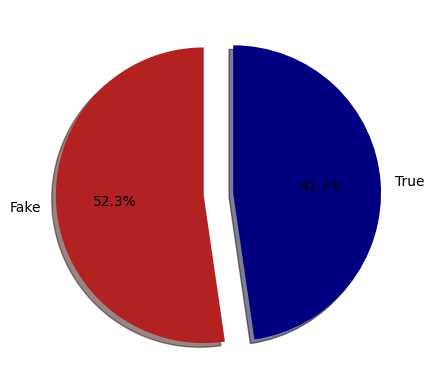

In [ ]:

label_size = [data['label'].sum(),len(data['label'])-data['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],
        colors=['firebrick','navy'],
        startangle=90,
        shadow=True,
        labels=['Fake','True'],
        autopct='%1.1f%%')

In [ ]:

train_text, temp_text, train_labels, temp_labels = train_test_split(data['title'], data['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=data['Target'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)


In [ ]:

bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Text(0, 0.5, 'Number of texts')

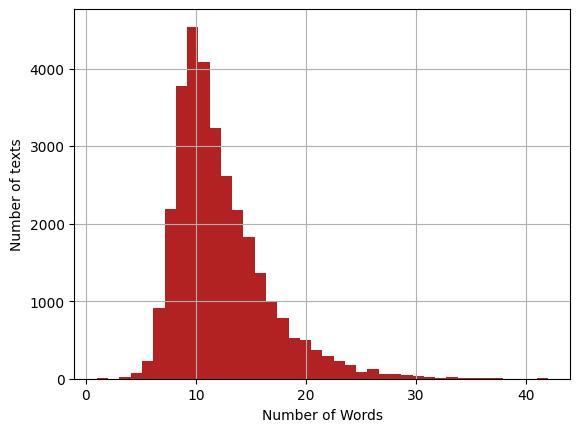

In [ ]:

seq_len = [len(title.split()) for title in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [ ]:

sample_data = ["Build fake news model.",
               "Using bert."]                                        
tokenized_sample_data = tokenizer.batch_encode_plus(sample_data,
                                                    padding=True)     
print(tokenized_sample_data)


{'input_ids': [[101, 3857, 8275, 2739, 2944, 1012, 102], [101, 2478, 14324, 1012, 102, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 0, 0]]}


In [ ]:

MAX_LENGHT = 15

tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

In [ ]:

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32  

train_w2v = get_word2vec_features(train_text.tolist(), word2vec_model)
val_w2v = get_word2vec_features(val_text.tolist(), word2vec_model)
test_w2v = get_word2vec_features(test_text.tolist(), word2vec_model)


train_w2v = torch.FloatTensor(train_w2v)
val_w2v = torch.FloatTensor(val_w2v)
test_w2v = torch.FloatTensor(test_w2v)


train_data = TensorDataset(train_seq, train_mask, train_w2v, train_y)
val_data = TensorDataset(val_seq, val_mask, val_w2v, val_y)
test_data = TensorDataset(test_seq, test_mask, test_w2v, test_y)

train_sampler = RandomSampler(train_data)                     
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_sampler = SequentialSampler(val_data)                    
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)


In [ ]:

for param in bert.parameters():
    param.requires_grad = False   

In [ ]:
class BERT_Arch(nn.Module):
    def __init__(self, bert, w2v_dim=300):
      super(BERT_Arch, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)            
      self.relu =  nn.ReLU()                    
      self.fc1 = nn.Linear(768 + w2v_dim, 512)  
      self.fc2 = nn.Linear(512, 2)              
      self.softmax = nn.LogSoftmax(dim=1)       

    def forward(self, sent_id, mask, w2v_features):           
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']

      combined_features = torch.cat([cls_hs, w2v_features], dim=1) 

      x = self.fc1(combined_features)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                          
      x = self.softmax(x)                      
      return x

model = BERT_Arch(bert)

from torch.optim import AdamW  
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          
cross_entropy  = nn.NLLLoss()
epochs = 3

In [ ]:

def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):                
    if step % 50 == 0 and not step == 0:                        
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  
    sent_id, mask, w2v, labels = batch
    model.zero_grad()                                           
    preds = model(sent_id, mask, w2v)                                
    loss = cross_entropy(preds, labels)                         
    total_loss = total_loss + loss.item()                       
    loss.backward()                                             
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     
    optimizer.step()                                            
    preds=preds.detach().cpu().numpy()                         

  avg_loss = total_loss / len(train_dataloader)                
  return avg_loss                                

def evaluate():
  print("\nEvaluating...")
  model.eval()                                    
  total_loss, total_accuracy = 0, 0
  for step,batch in enumerate(val_dataloader):    
    if step % 50 == 0 and not step == 0:          
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                 
    batch = [t for t in batch]                    
    sent_id, mask, w2v, labels = batch
    with torch.no_grad():                         
      preds = model(sent_id, mask, w2v)               
      loss = cross_entropy(preds,labels)          
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)       
  return avg_loss

In [ ]:

best_valid_loss = float('inf')
train_losses=[]                   
valid_losses=[]

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()                       
    valid_loss = evaluate()                    
    if valid_loss < best_valid_loss:              
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'c2_new_model_weight.pt')
    train_losses.append(train_loss)               
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 3
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  Batch   650  of    983.
  Batch   700  of    983.
  Batch   750  of    983.
  Batch   800  of    983.
  Batch   850  of    983.
  Batch   900  of    983.
  Batch   950  of    983.

Evaluating...
  Batch    50  of    211.
  Batch   100  of    211.
  Batch   150  of    211.
  Batch   200  of    211.

Training Loss: 0.453
Validation Loss: 0.272

 Epoch 2 / 3
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  

In [ ]:

path = 'c2_new_model_weight.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
with torch.no_grad():
  preds = model(test_seq, test_mask,test_w2v)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis=1)
print(classification_report(test_y, preds, target_names=['True', 'Fake']))

              precision    recall  f1-score   support

        True       0.99      1.00      0.99      3212
        Fake       1.00      0.99      0.99      3523

    accuracy                           0.99      6735
   macro avg       0.99      0.99      0.99      6735
weighted avg       0.99      0.99      0.99      6735



In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/pcd/c2_new_model_weight.pt')

**Évaluer sur le jeu de test**

In [ ]:
test_dataloader = DataLoader(
    test_data,
    sampler=SequentialSampler(test_data),
    batch_size=32
)

Accuracy: 0.9928730512249443
F1-Score: 0.9928745334780716

Classification Report:
               precision    recall  f1-score   support

        True       0.99      1.00      0.99      3212
        Fake       1.00      0.99      0.99      3523

    accuracy                           0.99      6735
   macro avg       0.99      0.99      0.99      6735
weighted avg       0.99      0.99      0.99      6735



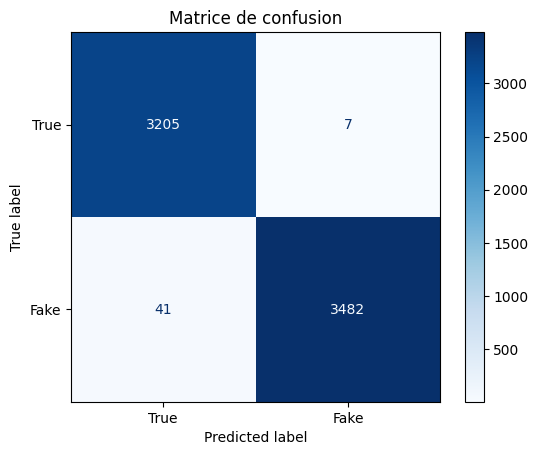

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

true_labels = []
pred_labels = []


model.to(device)  

with torch.no_grad():
    for batch in test_dataloader:
        sent_id, mask, w2v, labels = batch
        
        sent_id, mask, w2v, labels = sent_id.to(device), mask.to(device), w2v.to(device), labels.to(device)

        outputs = model(sent_id, mask, w2v)
        preds = torch.argmax(outputs, dim=1)  

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())


print("Accuracy:", accuracy_score(true_labels, pred_labels))
print("F1-Score:", f1_score(true_labels, pred_labels, average='weighted'))
print("\nClassification Report:\n", classification_report(true_labels, pred_labels, target_names=['True', 'Fake']))


ConfusionMatrixDisplay.from_predictions(true_labels, pred_labels, display_labels=['True', 'Fake'], cmap='Blues')
plt.title("Matrice de confusion")
plt.show()

In [ ]:
tokenizer.save_pretrained('/content/drive/My Drive/pcd/bert_tokenizer')


('/content/drive/My Drive/pcd/bert_tokenizer/tokenizer_config.json',
 '/content/drive/My Drive/pcd/bert_tokenizer/special_tokens_map.json',
 '/content/drive/My Drive/pcd/bert_tokenizer/vocab.txt',
 '/content/drive/My Drive/pcd/bert_tokenizer/added_tokens.json',
 '/content/drive/My Drive/pcd/bert_tokenizer/tokenizer.json')